# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score,recall_score,f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## Import the dataset

In [2]:
df = pd.read_csv('../data/name_embeds_complete_no_context.csv',index_col=0)

In [3]:
df.head()

,name,price,category,embeddings
0,Alete Abendbrei Bio Keksbrei 190g,1.29,Babybedarf,"[-0.047637939453125, 0.006134033203125, 0.0454..."
1,Alete Abendmahlzeit zum Trinken Mehrkorn-Getre...,1.99,Babybedarf,"[-0.033355712890625, 0.0202789306640625, 0.022..."
2,Alete Bio Apfel-Pfirsich mit Keks nach 4. Mona...,1.29,Babybedarf,"[-0.05810546875, 0.0166778564453125, 0.0557556..."
3,Alete Bio Banane-Apfel mit Vollkorn-Getreide 190g,1.29,Babybedarf,"[-0.0217742919921875, 0.0098724365234375, 0.04..."
4,Alete Bio Erbseneintopf 250g,1.59,Babybedarf,"[-0.03509521484375, 0.01074981689453125, 0.061..."


The embeddings are stored as lists for each product. In order to use them as features these lists have to be divided, such that each comma-separated value yields a new column --> since the output of mixtral produces 1024 embedings we will receive 1024 columns for the features. Instead of blowing up the dataframe we store the features directly as vectors in a numpy array:

In [4]:
# convert embeddings column to numpy array of dimension 1000 x 1024 - every product name embedding has 1024 features
import ast 
embeddings = df.embeddings.tolist()
embeddings_list = [ast.literal_eval(s) for s in embeddings]
X = np.array(embeddings_list) 
y = df.category

In [5]:
# create train and test set for the training of the basline model
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

As a Basline model we train a logisitic regression model with the embeddings (without context) as features and the product categories as targets.

In [6]:
clf = LogisticRegression(max_iter=1000).fit(X_train,y_train)
pred = clf.predict(X_test)

In [26]:
# export LogisitcRegression model
import pickle

with open("LogReg_model.pkl","wb") as f: # save the model in .pkl file
    pickle.dump(clf,f)

In [7]:
print(classification_report(y_test,pred))

                              precision    recall  f1-score   support

                  Babybedarf       0.96      0.80      0.88       101
Brot, Cerealien & Aufstriche       0.77      0.75      0.76       332
         Drogerie & Kosmetik       0.92      0.93      0.92       438
  Fertiggerichte & Konserven       0.75      0.84      0.79       499
             Fleisch & Fisch       0.84      0.83      0.84       249
     Getränke & Genussmittel       0.95      0.98      0.96       706
             Haus & Freizeit       0.92      0.65      0.76        84
         Kaffee, Tee & Kakao       0.97      0.88      0.92       160
             Kochen & Backen       0.82      0.70      0.75       272
       Käse, Eier & Molkerei       0.84      0.85      0.84       379
            Küche & Haushalt       0.86      0.90      0.88       269
               Obst & Gemüse       0.89      0.46      0.60        70
            Süßes & Salziges       0.76      0.89      0.82       477
                Tie

The basline model already seems to perform quite well, although we have not improved the embeddings (see embedings_api.ipynb) - the embeddings already show a clustering of the products, however the clusters are rather poorly separated.
To check if the model is overfitting we also have a look at the classification report for the train data:

In [8]:
print(classification_report(y_train,clf.predict(X_train)))

                              precision    recall  f1-score   support

                  Babybedarf       0.98      0.77      0.86       304
Brot, Cerealien & Aufstriche       0.79      0.76      0.77      1020
         Drogerie & Kosmetik       0.90      0.95      0.93      1321
  Fertiggerichte & Konserven       0.76      0.88      0.82      1536
             Fleisch & Fisch       0.86      0.82      0.84       680
     Getränke & Genussmittel       0.94      0.99      0.97      1920
             Haus & Freizeit       0.91      0.68      0.77       268
         Kaffee, Tee & Kakao       0.97      0.89      0.93       503
             Kochen & Backen       0.81      0.73      0.77       801
       Käse, Eier & Molkerei       0.87      0.86      0.87      1129
            Küche & Haushalt       0.88      0.89      0.88       789
               Obst & Gemüse       0.97      0.48      0.64       207
            Süßes & Salziges       0.79      0.90      0.85      1564
                Tie

The train data performs only slightly better or rather the scores of the test and train data are close to each other which indicates, that the model is not overfitting.

In [9]:
labels = df.category.unique().tolist()

In [27]:
labels

['Babybedarf',
 'Brot, Cerealien & Aufstriche',
 'Drogerie & Kosmetik',
 'Fertiggerichte & Konserven',
 'Fleisch & Fisch',
 'Getränke & Genussmittel',
 'Haus & Freizeit',
 'Kaffee, Tee & Kakao',
 'Kochen & Backen',
 'Käse, Eier & Molkerei',
 'Küche & Haushalt',
 'Obst & Gemüse',
 'Süßes & Salziges',
 'Tiefkühlkost',
 'Tierbedarf',
 'Öle, Soßen & Gewürze']

Text(49.76909722222221, 0.5, 'True')

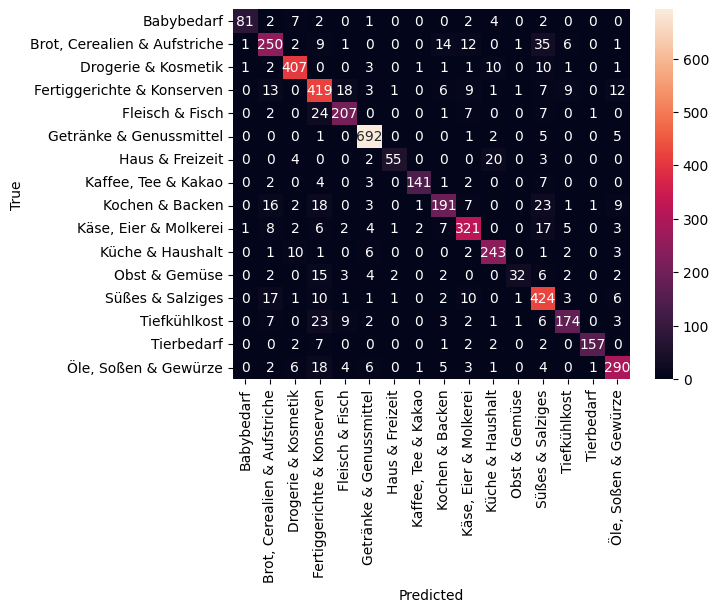

In [10]:
# Print confusion matrix
sns.heatmap(confusion_matrix(y_test,pred),annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')

For reference we also try different basic models: DecisionTree and RandomForest

In [11]:
clf_tree = DecisionTreeClassifier(max_depth=12).fit(X_train,y_train)
pred_tree = clf_tree.predict(X_test)

In [12]:
print(classification_report(y_train,clf_tree.predict(X_train)))

                              precision    recall  f1-score   support

                  Babybedarf       0.41      0.29      0.34       304
Brot, Cerealien & Aufstriche       0.37      0.57      0.45      1020
         Drogerie & Kosmetik       0.73      0.79      0.76      1321
  Fertiggerichte & Konserven       0.42      0.73      0.53      1536
             Fleisch & Fisch       0.57      0.53      0.55       680
     Getränke & Genussmittel       0.89      0.85      0.87      1920
             Haus & Freizeit       0.90      0.48      0.62       268
         Kaffee, Tee & Kakao       0.79      0.57      0.66       503
             Kochen & Backen       0.63      0.42      0.51       801
       Käse, Eier & Molkerei       0.80      0.69      0.74      1129
            Küche & Haushalt       0.79      0.65      0.71       789
               Obst & Gemüse       0.51      0.21      0.29       207
            Süßes & Salziges       0.65      0.72      0.68      1564
                Tie

In [13]:
print(classification_report(y_test,pred_tree))

                              precision    recall  f1-score   support

                  Babybedarf       0.20      0.13      0.16       101
Brot, Cerealien & Aufstriche       0.19      0.30      0.23       332
         Drogerie & Kosmetik       0.48      0.52      0.50       438
  Fertiggerichte & Konserven       0.27      0.49      0.34       499
             Fleisch & Fisch       0.38      0.32      0.35       249
     Getränke & Genussmittel       0.74      0.66      0.70       706
             Haus & Freizeit       0.26      0.15      0.19        84
         Kaffee, Tee & Kakao       0.41      0.31      0.36       160
             Kochen & Backen       0.30      0.19      0.23       272
       Käse, Eier & Molkerei       0.50      0.44      0.47       379
            Küche & Haushalt       0.39      0.30      0.34       269
               Obst & Gemüse       0.10      0.04      0.06        70
            Süßes & Salziges       0.42      0.46      0.44       477
                Tie

The decision tree is much less effective in predicting the right categories, than the logistic regression. The performance of the RandomForest is comparable to the DecisionTree and also worse than the LogisticRegression

In [14]:
clf_forest = RandomForestClassifier(min_samples_leaf=5,max_depth=5).fit(X_train,y_train)
pred_forest = clf_forest.predict(X_test)


In [15]:
print(classification_report(y_test,pred_forest))

                              precision    recall  f1-score   support

                  Babybedarf       0.00      0.00      0.00       101
Brot, Cerealien & Aufstriche       0.00      0.00      0.00       332
         Drogerie & Kosmetik       0.57      0.86      0.68       438
  Fertiggerichte & Konserven       0.28      0.84      0.42       499
             Fleisch & Fisch       0.00      0.00      0.00       249
     Getränke & Genussmittel       0.63      0.99      0.77       706
             Haus & Freizeit       0.00      0.00      0.00        84
         Kaffee, Tee & Kakao       0.00      0.00      0.00       160
             Kochen & Backen       0.00      0.00      0.00       272
       Käse, Eier & Molkerei       0.90      0.50      0.65       379
            Küche & Haushalt       1.00      0.03      0.05       269
               Obst & Gemüse       0.00      0.00      0.00        70
            Süßes & Salziges       0.35      0.87      0.50       477
                Tie

/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [16]:
print(classification_report(y_train,clf_forest.predict(X_train)))

                              precision    recall  f1-score   support

                  Babybedarf       0.00      0.00      0.00       304
Brot, Cerealien & Aufstriche       1.00      0.00      0.01      1020
         Drogerie & Kosmetik       0.59      0.89      0.71      1321
  Fertiggerichte & Konserven       0.31      0.88      0.46      1536
             Fleisch & Fisch       0.00      0.00      0.00       680
     Getränke & Genussmittel       0.64      0.99      0.78      1920
             Haus & Freizeit       0.00      0.00      0.00       268
         Kaffee, Tee & Kakao       1.00      0.00      0.00       503
             Kochen & Backen       0.00      0.00      0.00       801
       Käse, Eier & Molkerei       0.87      0.57      0.69      1129
            Küche & Haushalt       1.00      0.07      0.13       789
               Obst & Gemüse       0.00      0.00      0.00       207
            Süßes & Salziges       0.39      0.91      0.55      1564
                Tie

/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Finally, we try out an XGB model:

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [18]:
df['category'] = pd.Categorical(df.category)
df['num_category'] = df.category.cat.codes

In [19]:
y2 = df.num_category

In [20]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X,y2,random_state=42)

In [21]:
xgb = XGBClassifier(random_state=42)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

#grid_obj_xgb = RandomizedSearchCV(xgb,param_distributions=params, n_iter=5, scoring='roc_auc',n_jobs=-1,verbose=1)

# perform simple model training with the default parameters first, before doing a grid search
fit_xgb = xgb.fit(X_train_xgb,y_train_xgb)

# Get the estimator
#best_clf_xgb = grid_fit_xgb.best_estimator_

pred_xgb = fit_xgb.predict(X_test_xgb)

In [25]:
# export XGBoost model
import pickle

with open("xbg_model.pkl","wb") as f: # save the model in .pkl file
    pickle.dump(fit_xgb,f)

Text(49.76909722222221, 0.5, 'True')

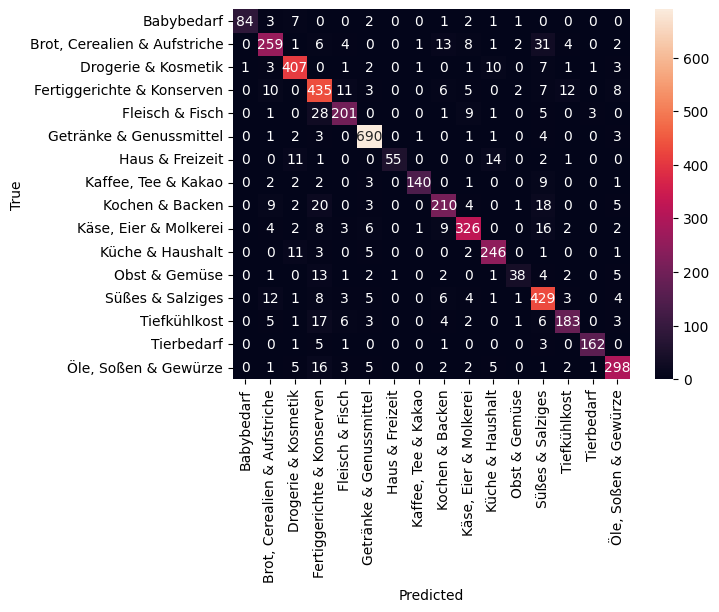

In [22]:
sns.heatmap(confusion_matrix(y_test_xgb,pred_xgb),annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')

In [23]:
print(classification_report(y_test_xgb,pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       101
           1       0.83      0.78      0.81       332
           2       0.90      0.93      0.91       438
           3       0.77      0.87      0.82       499
           4       0.86      0.81      0.83       249
           5       0.95      0.98      0.96       706
           6       0.98      0.65      0.79        84
           7       0.97      0.88      0.92       160
           8       0.82      0.77      0.80       272
           9       0.89      0.86      0.87       379
          10       0.88      0.91      0.89       269
          11       0.83      0.54      0.66        70
          12       0.79      0.90      0.84       477
          13       0.87      0.79      0.83       231
          14       0.97      0.94      0.95       173
          15       0.89      0.87      0.88       341

    accuracy                           0.87      4781
   macro avg       0.89   

Without optimization the XGBoost model outperforms the LogisiticRegression, but there is surely even more to get out of it.